<a href="https://colab.research.google.com/github/sankethgadadinni/DogsandCatsImageClassification/blob/main/DogsvsCatsKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Mon Dec 14 08:53:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install kaggle

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sankethgadadinni","key":"f6711e33d3a8e8d7a3b2198fa9f4f8bd"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 99% 537M/544M [00:16<00:00, 58.7MB/s]
100% 544M/544M [00:16<00:00, 33.7MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 116MB/s]
 96% 261M/271M [00:05<00:00, 75.6MB/s]
100% 271M/271M [00:06<00:00, 47.1MB/s]


In [7]:
from zipfile import ZipFile
file_name = 'train.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [8]:
from zipfile import ZipFile
file_name = 'test.zip'

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('done')

done


In [9]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader,Dataset


In [10]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

In [11]:
train_path = '/content/train'
test_path = '/content/test'

In [12]:
train_img_files = os.listdir(train_path)
len(train_img_files)

25000

In [13]:
test_img_files = os.listdir(test_path)
len(test_img_files)

12500

In [14]:
def train_path(p):
   return f"../content/train/{p}"
img_files = list(map(train_path, train_img_files))

In [15]:
class DogsVsCats(Dataset):
  def __init__(self, img_paths, transform):
    super().__init__()

    self.transform = transform
    self.paths = img_paths
    self.len = len(self.paths)

  def __len__(self):
    return self.len

  def __getitem__(self, index):

    path = self.paths[index]
    image = Image.open(path).convert('RGB')
    image = self.transform(image)

    label = 0 if 'cat' in path else 1

    return (image,label)



In [16]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])

In [17]:
import random
random.shuffle(img_files)
train_files = img_files[:20000]
valid_files = img_files[20000:]

In [18]:
#dataset = DogsVsCats(train_path,transform=data_transform)

In [19]:
train_dataset = DogsVsCats(train_files, data_transform)
train_loader = DataLoader(train_dataset, batch_size=64)

len(train_dataset), len(train_loader)

(20000, 313)

In [20]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

Image shape:  torch.Size([64, 3, 224, 224])


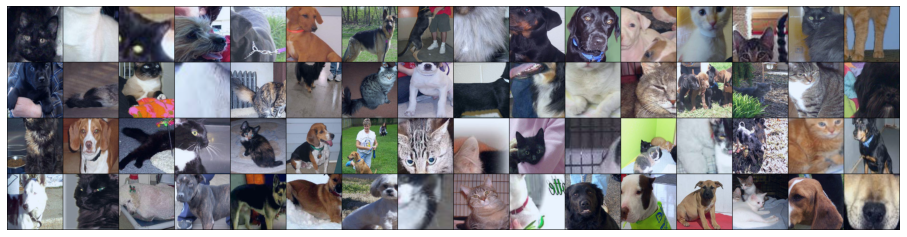

In [21]:
for imgs, _ in train_loader:
    print('Image shape: ', imgs.shape)
    plt.figure(figsize=(16, 10))
    plt.axis('off')
    plt.imshow(make_grid(imgs, nrow=16, normalize=True).permute(1, 2, 0))
    break

In [22]:
val_dataset = DogsVsCats(valid_files, data_transform)
val_loader = DataLoader(val_dataset, batch_size=64)

len(val_dataset), len(val_loader)


(5000, 79)

In [23]:
model = torchvision.models.resnet50(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
for param in model.parameters():
    param.requires_grad = False

fc_in_features = model.fc.in_features
model.fc = nn.Linear(fc_in_features, 2)
model = model.to(device)

In [25]:
import time
import copy


In [26]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

dataloaders = {'train': train_loader,
                'val': val_loader}

dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset)}

def train_model(model, criterion, optimizer, dataloaders, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

     
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [27]:
trained_model = train_model(model, criterion, optimizer, dataloaders, scheduler=lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1836 Acc: 0.9323
val Loss: 0.1243 Acc: 0.9514

Epoch 1/4
----------
train Loss: 0.1252 Acc: 0.9504
val Loss: 0.1256 Acc: 0.9448

Epoch 2/4
----------
train Loss: 0.1141 Acc: 0.9553
val Loss: 0.0939 Acc: 0.9642

Epoch 3/4
----------
train Loss: 0.1127 Acc: 0.9543
val Loss: 0.1030 Acc: 0.9588

Epoch 4/4
----------
train Loss: 0.1150 Acc: 0.9539
val Loss: 0.1050 Acc: 0.9570

Training complete in 12m 39s
Best val Acc: 0.964200


In [28]:
def test_path(p):
   return f"../content/test/{p}"
test_files = list(map(test_path, test_img_files))

In [29]:

labels = []


with torch.no_grad():
    for test_img in test_files:
        img = Image.open(test_img)
        img = data_transform(img)
        img = img.unsqueeze(0)
        img = img.to(device)
        
        trained_model.eval()
        output = trained_model(img)
        pred = F.softmax(output, dim=1)[:, 1].tolist()
        
        labels.append(pred[0])


In [30]:
import pandas as pd

In [31]:
df = pd.read_csv('/content/sample_submission.csv')

In [32]:
df['label'] = labels

In [33]:
df.head()

,id,label
0,1,0.999338
1,2,0.998938
2,3,0.006913
3,4,0.000398
4,5,0.995760


In [34]:
df.to_csv('subm_2.csv', index=False)